### Import necessary libraries. 

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
import imblearn 
from imblearn.over_sampling import SMOTE # Oversampling
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

<b>Read data file</b>

In [3]:
#sets the maximum number of columns and rows displayed when a frame is pretty-printed
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

In [22]:
df = pd.read_csv('bankruptcy.csv')
#Replace the categorical column (class) values into binary
df['class']=pd.Categorical(df['class'].replace({"b'0'" : 0, "b'1'":1}))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Attr1   10503 non-null  float64 
 1   Attr2   10503 non-null  float64 
 2   Attr3   10503 non-null  float64 
 3   Attr4   10485 non-null  float64 
 4   Attr5   10478 non-null  float64 
 5   Attr6   10503 non-null  float64 
 6   Attr7   10503 non-null  float64 
 7   Attr8   10489 non-null  float64 
 8   Attr9   10500 non-null  float64 
 9   Attr10  10503 non-null  float64 
 10  Attr11  10503 non-null  float64 
 11  Attr12  10485 non-null  float64 
 12  Attr13  10460 non-null  float64 
 13  Attr14  10503 non-null  float64 
 14  Attr15  10495 non-null  float64 
 15  Attr16  10489 non-null  float64 
 16  Attr17  10489 non-null  float64 
 17  Attr18  10503 non-null  float64 
 18  Attr19  10460 non-null  float64 
 19  Attr20  10460 non-null  float64 
 20  Attr21  9696 non-null   float64 
 21  Attr22  1050

In [23]:
# Change the class variable from categorical to integer
df['class']= pd.Categorical(df['class']).codes
# Find top 20 columns with most null values
print(df.isnull().sum().sort_values(ascending=False).head(20))      

Attr37    4736
Attr21     807
Attr27     715
Attr60     592
Attr45     591
Attr28     228
Attr53     228
Attr54     228
Attr64     228
Attr24     227
Attr41     202
Attr32     101
Attr47      86
Attr52      86
Attr30      43
Attr20      43
Attr49      43
Attr23      43
Attr56      43
Attr39      43
dtype: int64


<BarContainer object of 65 artists>

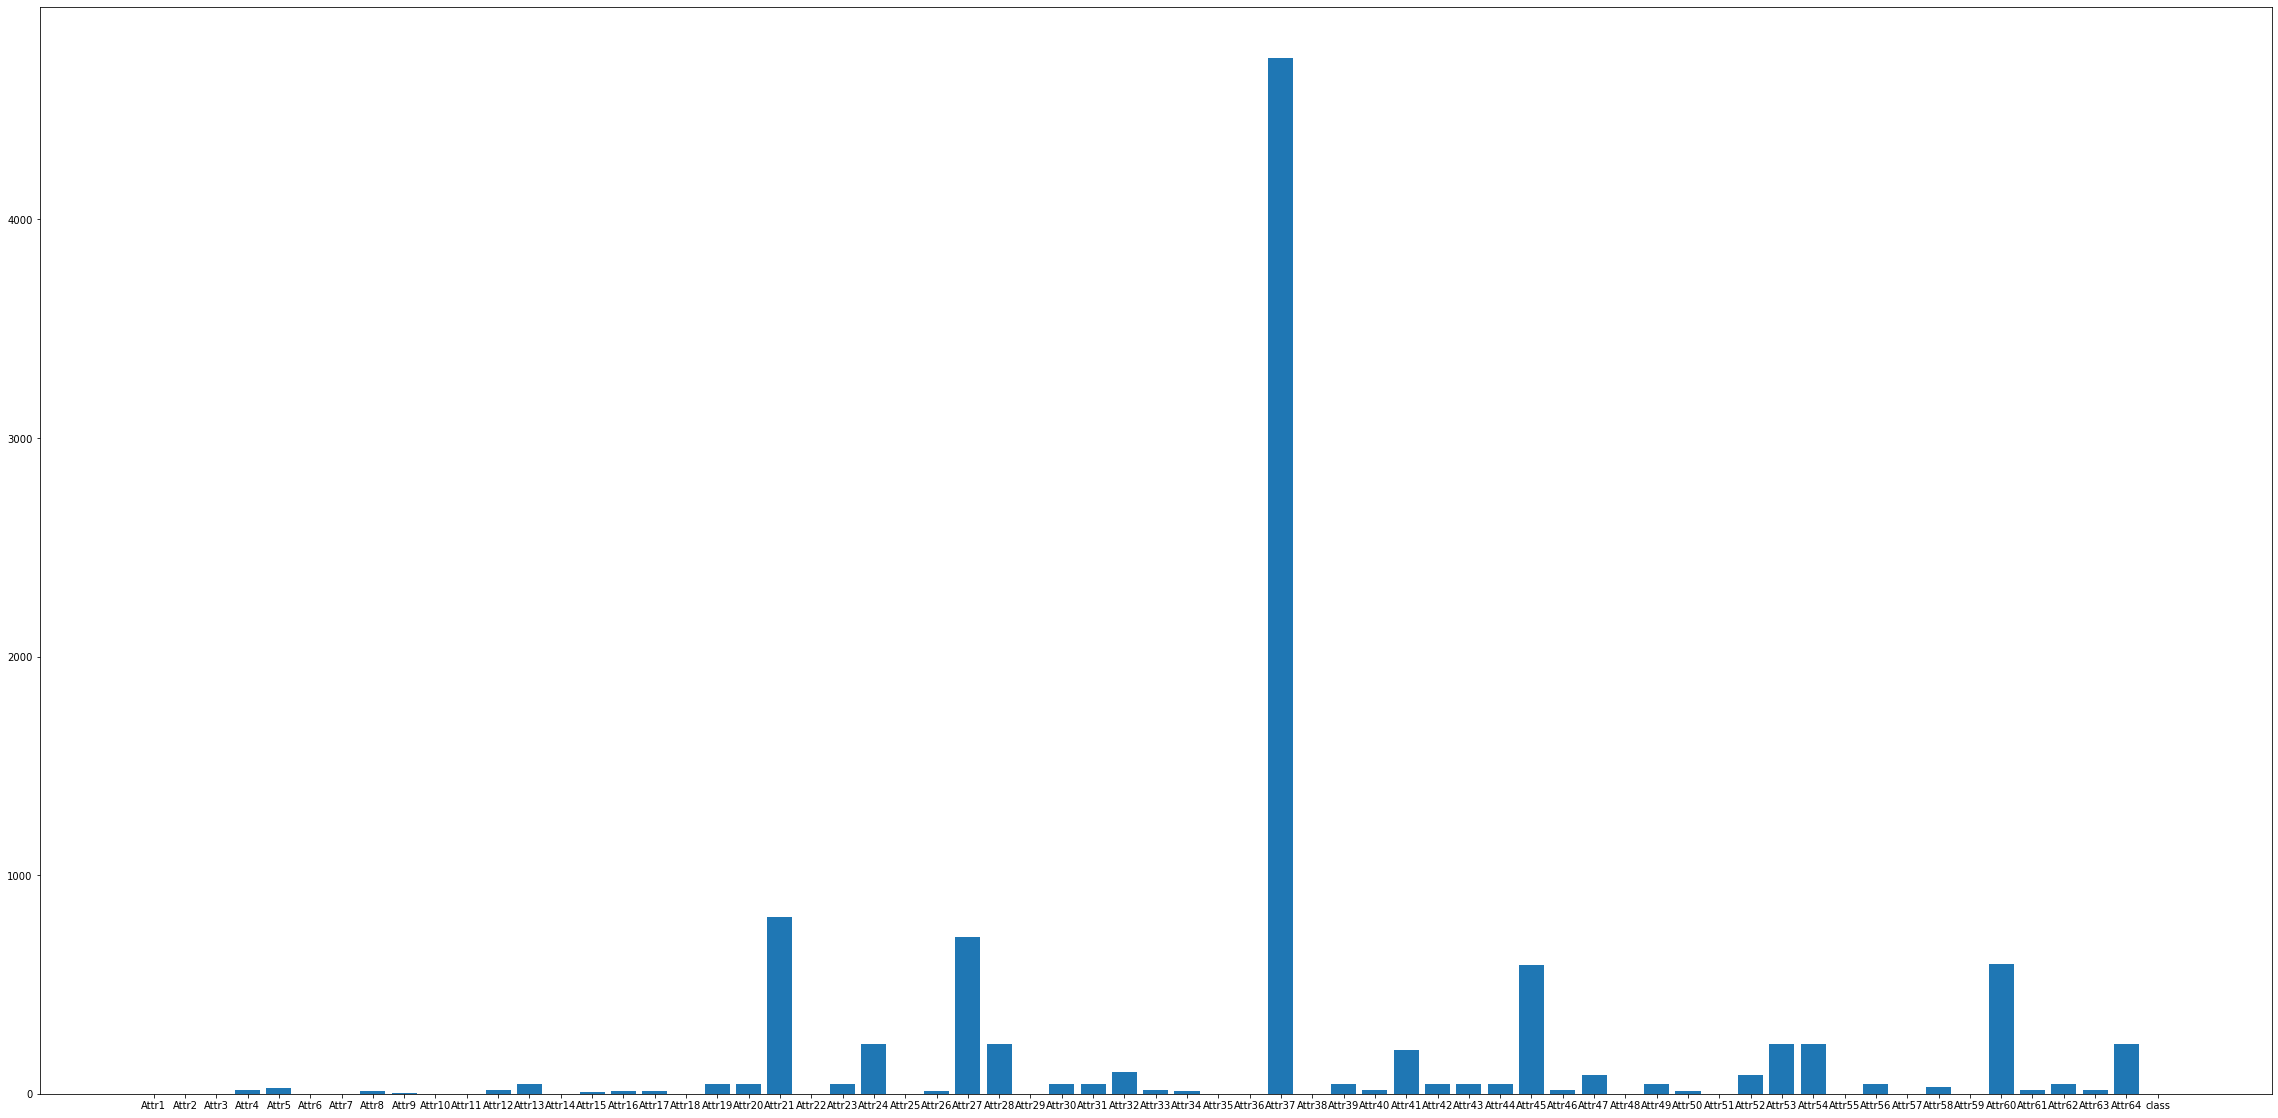

In [24]:
#replace the null values with 'nan'
df = df.replace('', np.nan)
nan_columns = []
nan_values = []
#count the number of  nan values in Dataset and plot a bargraph
for column in df.columns:
    nan_columns.append(column)
    nan_values.append(df[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

Column Attr37 contains the highest number of "Nan" values and data imputation on the column will nto be useful. Remove the column and plot the bar graph again

<BarContainer object of 64 artists>

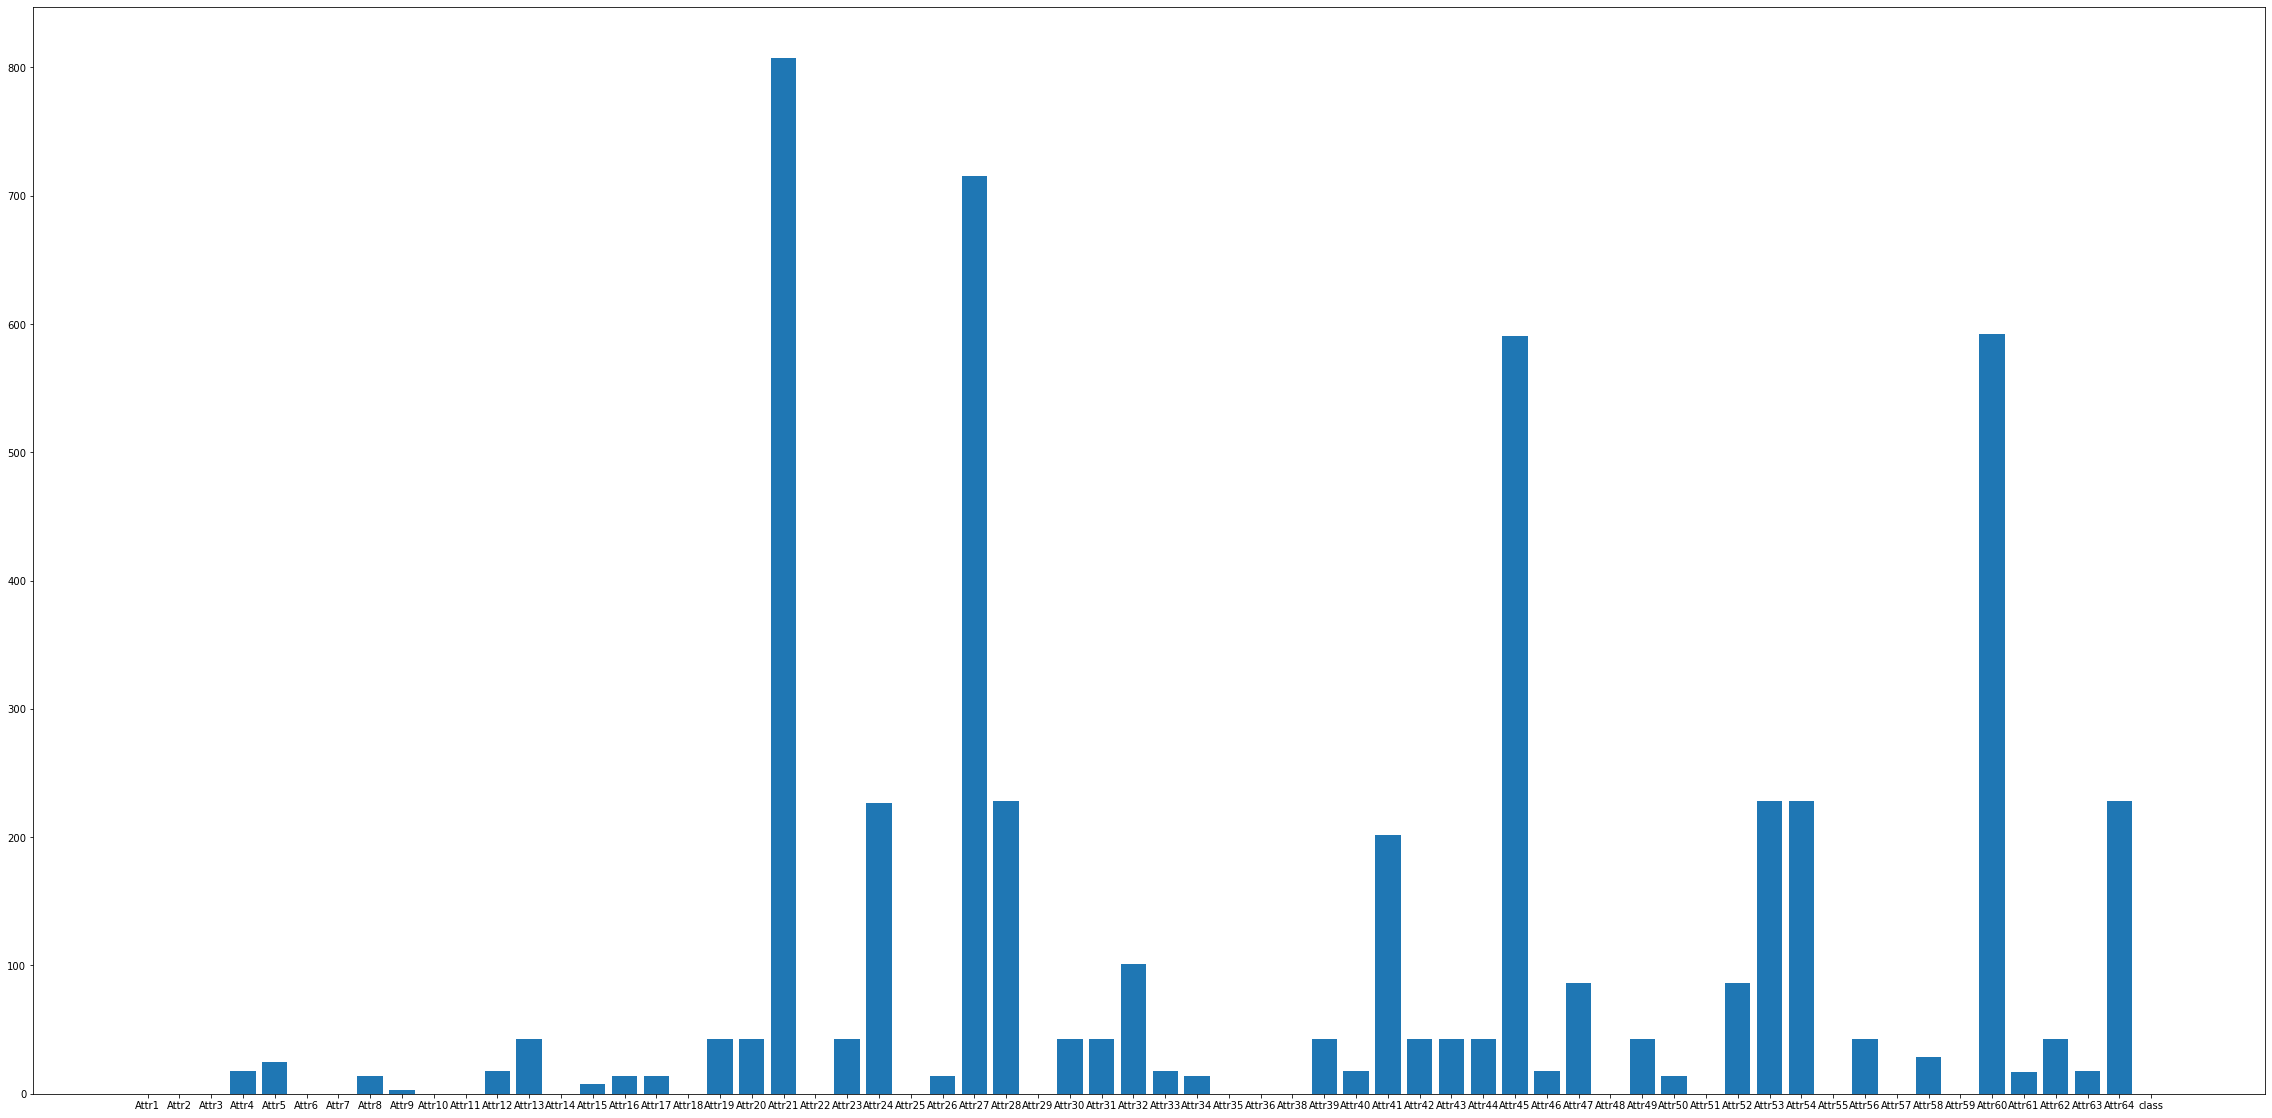

In [25]:
# Delete the column with highest number of nan values ie Column Attr37
df = df.drop(columns = ['Attr37'])
# Plot the null values graph after removing the Attr37 column
nan_columns = []
nan_values  = []

for column in df.columns:
    nan_columns.append(column)
    nan_values.append(df[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

<AxesSubplot:xlabel='class', ylabel='count'>

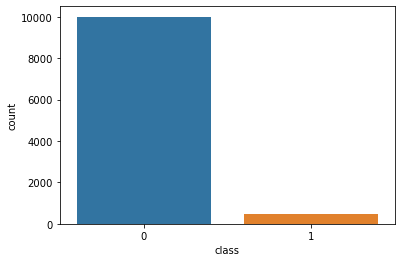

In [26]:
sns.countplot(x='class', data=df)

Summary: Our data is highly imbalanced. The event rate of a company being bankrupt will be around 4.71% based on the data set provided.
In order to get a better accuracy rate instead of imputing the data as a whole we impute based on the 'class' attribute values. Create two different data frames according to the 'class' values and then concatenate the imputed data frames.

In [27]:
df_class_zero = df[df['class']==0]
df_class_one = df[df['class']==1]

## Data Imputation

In [41]:
# Method to perform imputation on data frame. Pass data frame and the strategy via which imputation is to be carried out. 
def Imputation(data, approach):
    imputer = SimpleImputer(strategy = approach, missing_values = np.nan)
    imputer = imputer.fit(data)
    data_return = pd.DataFrame(imputer.transform(data.loc[:,:]), 
                             columns = data.columns)
  #  print("\f Imputed data via strategy: ", approach )
    return data_return

In [42]:
#Data imputation via median on original data seperated by class
df_median_imputed_zero = df_class_zero.copy()
df_median_imputed_zero = Imputation(df_median_imputed_zero, 'median')
df_median_imputed_one = df_class_one.copy()
df_median_imputed_one = Imputation(df_median_imputed_one, 'median')
df_median_imputed = df_median_imputed_zero.append([df_median_imputed_one])
df_median_imputed.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.966167,-1.344447e+03,-0.121159,0.065624,19.116068,1.819070,0.366093,0.086764,2.407406,0.375292,0.065634,3.002654e+03,2.726329,20.487054,0.070739,-0.169947,68.310497,4.385225,0.075676,-0.175632,0.210998,0.196153,2.577577,1.105281e+03,5.970487,3.921179,0.458367,-0.176198,1.161146e+03,8.413460,5.393889,0.071075,1.981250,0.465510,-0.075906,2.377282,28.156578,-0.140949,194.995581,126.642835,16.484166,8.964458,5.383505e+02,0.004834,-0.216928,8.676086,0.497135,11.153809,5.627422,6.592662,6.638549e+03,-0.527703,-0.014817,3.840801,1.429319,5.396899e+02,13.923654,1.352757e+02,9.088363,35.078624,0.047129
std,0.647797,6.427041,6.420056,523.243080,1.184394e+05,6.970625,0.651152,717.278474,7.580584,6.428603,0.655407,111.364122,49.573752,0.651151,1.091565e+05,110.160013,721.331800,0.835328,11.187235,1081.481194,293.911052,0.581734,11.126433,2.071102,6.742161,108.751468,3.349082e+04,93.683591,0.840528,71.607994,11.134148,6.808302e+04,37.664766,68.989341,0.572124,2.630705,6.425362,8.062780,37.787522,2817.796456,10.765453,3296.545706,2760.839921,1671.239869,523.116826,3.113592e+04,0.629770,11.886534,522.179994,6.420885,848.373390,88.731371,92.494159,5.989196e+04,55.863902,18.684047,189.938495,77.273270,3.609736e+04,83.636834,2.593790e+04,31.392591,423.648786,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-1543.800000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040900,-5.196150e+01,0.000000,0.002118,0.431935,1.011350,0.297340,0.009809,0.006372,0.020868,0.002131,1.867450e+02,0.060454,1.450350,0.002131,0.001742,14.400500,0.813550,0.000000,0.000639,0.017663,0.135695,0.055273,1.449050e-02,0.035968,3.393200,0.074598,0.004132,4.511250e+01,2.789700,0.370620,0.001730,1.043500,0.426810,0.001677,0.053836,0.022861,0.000000,65.740000,34.298000,0.014509,0.603425,1.514850e+01,-0.048988,-0.035852,0.749810,0.177200,0.123250,0.680975,0.958225,1.462100e+01,0.005336,0.006796,0.875700,0.000000,5.734300e+00,4.490600,4.092850e+01,3.064050,2.055600,0.000000
50%,0.043034,0.464140,0.198560,1.607500,1.713300e+00,0

## Outlier detection & Treatment
Outliers are observations that are far away from the other data points in a random sample of a population. We often want to make assumptions about a specific population. Extreme values can have a significant impact on conclusions drawn from data.

<b>Commonly used methods for detection of outliers is:</b> 
1. Tukey’s box plot method-
    Tukey distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer       fence, whereas a probable outlier is located outside the outer fence.
2. z-score method-
    For each observation (Xn), it is measured how many standard deviations the data point is away from its mean (X̄).
3. Median Absolute Deviation method-
    Replaces the mean and standard deviation with more robust statistics, like the median and median absolute deviation. 
4. Isolation Forest: It explicitly isolates anomalies instead of profiling and constructing normal points and regions by assigning a score to each data point. It takes advantage of the fact that anomalies are the minority data points and that they have attribute-values that are very different from those of normal instances. 

In [15]:
# Check the skewness of the data before the outlier treatment
df_median_imputed.skew(axis = 0)

Attr1      51.971750
Attr2      71.596019
Attr3     -71.691576
Attr4     101.392697
Attr5     -96.973066
Attr6     -69.367311
Attr7      51.122493
Attr8      57.629129
Attr9      89.251692
Attr10    -71.532339
Attr11     50.325599
Attr12     63.855413
Attr13     95.595825
Attr14     51.122608
Attr15     78.046506
Attr16     66.222372
Attr17     56.901407
Attr18     49.391027
Attr19    -56.105443
Attr20     72.157172
Attr21    100.453767
Attr22     49.436071
Attr23    -56.870025
Attr24     59.385911
Attr25    -70.658843
Attr26     68.129584
Attr27     60.679954
Attr28     40.724742
Attr29     -0.030266
Attr30    -58.811629
Attr31    -57.022819
Attr32     91.538164
Attr33     50.013503
Attr34     75.125077
Attr35     52.688413
Attr36     31.606763
Attr38    -71.684939
Attr39    -52.690921
Attr40     53.795515
Attr41    102.473398
Attr42    -57.960029
Attr43     61.682816
Attr44     78.452008
Attr45     40.549943
Attr46    101.471037
Attr47     74.792720
Attr48     38.217771
Attr49    -60

In [16]:
# Method for outlier detection via Inter-quartile range method: 
def outlier_detection_IQR(x, scale):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - scale * IQR 
    upper = Q3 + scale * IQR  
    outliers = ((x<lower)| (x>upper)).sum()
    total_length = len(x.index)
    percent_outlier = (outliers * 100 / total_length).round(3)
    print(x.name, "\tTotal outliers is: ", outliers,"\t", "\t Percentage Outliers: ", percent_outlier )    

In [29]:
# check number of Outliers in all columns
# Scale is 1.5 (Popular)
scale = 1.5
for column in df_median_imputed:
    outlier_detection_IQR(df_median_imputed[column], scale)

Attr1 	Total outliers is:  1266 	 	 Percentage Outliers:  12.054
Attr2 	Total outliers is:  290 	 	 Percentage Outliers:  2.761
Attr3 	Total outliers is:  271 	 	 Percentage Outliers:  2.58
Attr4 	Total outliers is:  1118 	 	 Percentage Outliers:  10.645
Attr5 	Total outliers is:  1567 	 	 Percentage Outliers:  14.92
Attr6 	Total outliers is:  3170 	 	 Percentage Outliers:  30.182
Attr7 	Total outliers is:  1139 	 	 Percentage Outliers:  10.845
Attr8 	Total outliers is:  1150 	 	 Percentage Outliers:  10.949
Attr9 	Total outliers is:  726 	 	 Percentage Outliers:  6.912
Attr10 	Total outliers is:  305 	 	 Percentage Outliers:  2.904
Attr11 	Total outliers is:  1012 	 	 Percentage Outliers:  9.635
Attr12 	Total outliers is:  1526 	 	 Percentage Outliers:  14.529
Attr13 	Total outliers is:  1113 	 	 Percentage Outliers:  10.597
Attr14 	Total outliers is:  1139 	 	 Percentage Outliers:  10.845
Attr15 	Total outliers is:  1801 	 	 Percentage Outliers:  17.147
Attr16 	Total outliers is:  13

In [30]:
# Method for outlier detection via Isolation forest method: 
def outlier_detection_IF(df_input):
    model = IsolationForest(n_estimators = 50, max_samples='auto', contamination=float(0.1))#, max_features=1.0)
    model.fit(df_input)
    df_input['scores']=model.decision_function(df_input)
    df_input['anomaly']=model.predict(df_input)
    anomaly=df_input.loc[df['anomaly']==-1]
    anomaly_index=list(anomaly.index)
    print("\f The total number of anomalities in data is ", len(anomaly))
    return anomaly

In [ ]:
# Check outliers in median imputed data. 
anomalities = outlier_detection_IF(df_median_imputed)
anomalities.describe()

<b>For the treatement of outliers there are several methods:</b>
1. Quantile-based Flooring and Capping:
    Here points below 10th percentile are replaced with 10th percentile values
    and  points above 90th percentile are replaced with 90th percentile values.
    
2. Trimming:
      We completely remove data points that are outliers. This changes the total number of data rows present largely for our         bankruptcy data
    
3. IQR Score:
    The rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed
    
4. Log Transformation:
    Each cell could be transformed to a new value by formulating logarithmic, square, square root etc. But since we have           negative values too we cannot use this method
    
5. Replacing Outliers with Median Values:
    We calculate the median and assign those values to the upper and lower datapoints

In [21]:
# Outlier treatment (Replacing Outliers with Median Values)
def outlier_treatment(attr,threshold):
    Q1 = attr.quantile(0.25)
    Q2 = attr.quantile(0.50)
    Q3 = attr.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR 
    upper = Q3 + threshold * IQR 
    if (attr.name != 'class'):
        df_median_treated[attr.name] = np.where((df_median_treated[attr.name]>upper)|(df_median_treated[attr.name]<lower), Q2 , df_median_treated[attr.name])

In [64]:
df_median_treated = df_median_imputed.copy()
for column in df_median_treated:
    outlier_treatment(df_median_treated[column], scale)
    
df_median_treated.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000
mean,0.055132,0.471526,0.226989,1.795662,2.054818,0.008607,0.064839,1.376810,1.416886,0.512450,0.079971,0.200027,0.074343,0.064850,982.063898,0.278770,2.426289,0.064848,0.041001,38.288824,0.944465,0.068338,0.035468,0.184529,0.384008,0.252763,1.265717,0.562137,3.922662,0.230064,0.048471,82.997360,5.105333,2.498695,0.067020,1.673840,0.606513,0.043840,0.304127,0.092559,0.044533,101.000090,56.108632,0.322576,1.181169,41.360801,0.023854,0.014356,1.365626,0.355045,0.227046,1.272509,1.465594,1401.824380,0.060603,0.125739,0.943544,0.066428,11.019859,6.999467,75.926598,5.590664,4.702745,0.047129
std,0.087436,0.270816,0.287738,1.136496,69.911568,0.040741,0.100878,1.396941,0.712612,0.268852,0.107252,0.363972,0.076890,0.100873,1291.970941,0.367563,1.434655,0.100874,0.059653,30.632404,0.199487,0.101049,0.052128,0.246613,0.305054,0.334710,2.161646,0.849168,0.778408,0.231486,0.065574,51.628933,3.266952,2.566890,0.101575,0.887692,0.232288,0.061813,0.375244,0.103283,0.062189,50.009551,30.553047,0.538657,0.841701,33.677381,0.105885,0.065941,0.914180,0.225436,0.141329,0.902732,0.824863,2559.090079,0.085355,0.175138,0.082352,0.132909,7.804971,3.706451,47.405352,3.546314,3.976353,0.211926
min,-0.183050,0.000000,-0.583670,0.002080,-213.500000,-0.108380,-0.207790,-2.081800,-0.000084,-0.344980,-0.216090,-0.833330,-0.147280,-0.207790,-2801.200000,-0.808800,-0.043411,-0.207790,-0.126450,-0.001439,0.401060,-0.218350,-0.111910,-0.506570,-0.577780,-0.742820,-6.171600,-2.157100,1.816400,-0.450680,-0.137250,-0.002254,-1.921900,-5.502500,-0.213670,-0.000084,-0.115510,-0.131500,-0.411990,-0.229260,-0.136480,-0.293730,0.000000,-1.278100,-0.079512,-17.303000,-0.273230,-0.178470,0.002080,0.000000,0.000000,-1.631300,-1.182200,-6486.200000,-0.180910,-0.389200,0.695810,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.000000
25%,0.008169,0.253955,0.038011,1.040900,-31.855500,0.000000,0.010156,0.431935,1.011450,0.322885,0.020209,0.019745,0.029919,0.010170,326.960000,0.070906,1.450350,0.010170,0.009167,14.400500,0.830650,0.000285,0.007770,0.034574,0.175565,0.065605,0.270860,0.065864,3.410800,0.083637,0.013756,45.139500,2.789700,0.375165,0.009312,1.043500,0.457290,0.008606,0.053887,0.035830,0.004832,65.809500,34.307000,0.056535,0.603610,15.148500,-0.028060,-0.014228,0.749810,0.177200,0.123415,0.727015,0.993640,100.370000,0.014462,0.027493,0.905200,0.000000,5.734300,4.491000,40.938500,3.064050,2.055600,0.000000
50%,0.043034,0.464140,0.198560,1.607500,1.713300,0.000000,0.050945,1.112800,1.199000,0.515500,0.068104,0.156130,0.066725,0.050953,804.410000,0.235440,2.154500,0.050953,0.032454,34.332000,0.955370,0.054633,0.027351,0.165840,0.377690,0.213560,1.071050,0.476710,3.932100,0.215670,0.040055,76.851000,4.688

In [ ]:
# #Check the skewness of the data after the outlier treatment
#df_median_imputed.skew(axis = 0)

<AxesSubplot:>

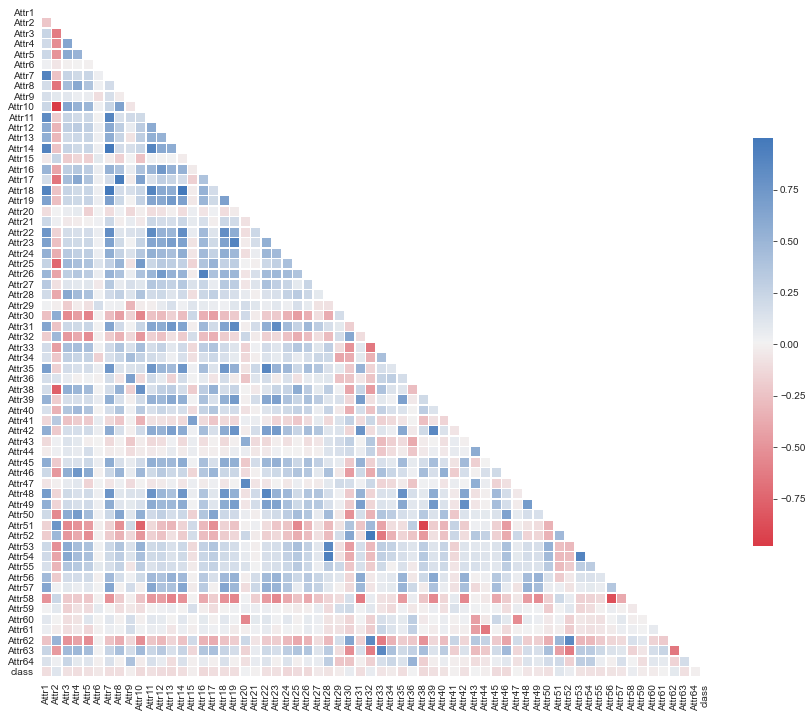

In [65]:
#Check Correlation matrix of median + outlier treated imputed data
corr_2 = df_median_treated.corr()
mask = np.triu(np.ones_like(corr_2, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
sns.set_style(style="white")
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_2, mask=mask,
            cmap=cmap,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            ax= ax,
            xticklabels = df_median_treated.columns.tolist(),
            yticklabels = df_median_treated.columns.tolist())

Create the correlation groups and finalize the variables according to the groups

In [33]:
def correlation_group(correlation, percentile):
    correlation_pairs = correlation.unstack()
    high_correlation = correlation_pairs[(correlation_pairs>=percentile)|(correlation_pairs<= -1*percentile)]
    print(high_correlation)

In [34]:
correlation_group(corr_2 , 0.85)

Attr1   Attr1     1.000000
        Attr7     0.914111
        Attr11    0.850580
        Attr14    0.914053
        Attr18    0.914074
Attr2   Attr2     1.000000
        Attr10   -0.979433
Attr3   Attr3     1.000000
Attr4   Attr4     1.000000
Attr5   Attr5     1.000000
Attr6   Attr6     1.000000
Attr7   Attr1     0.914111
        Attr7     1.000000
        Attr11    0.898072
        Attr14    0.999949
        Attr18    0.999968
Attr8   Attr8     1.000000
        Attr17    0.964113
Attr9   Attr9     1.000000
Attr10  Attr2    -0.979433
        Attr10    1.000000
Attr11  Attr1     0.850580
        Attr7     0.898072
        Attr11    1.000000
        Attr14    0.898008
        Attr18    0.898029
Attr12  Attr12    1.000000
Attr13  Attr13    1.000000
Attr14  Attr1     0.914053
        Attr7     0.999949
        Attr11    0.898008
        Attr14    1.000000
        Attr18    0.999998
Attr15  Attr15    1.000000
Attr16  Attr16    1.000000
        Attr26    0.919769
Attr17  Attr8     0.964113
 

Columns with attributes 1,7,11,14,22,35,48 show positive correlation(>0.85)
Columns with attributes 3,6,10,25,38,51    show negative correlation(<-0.85)<br>
<b>Attributes positive correlation: </b><br>
1. Attr1 -net profit / total assets
2. Attr7 -EBIT(Earnings before interest and taxes) / total assets
3. Attr11-(gross profit + extraordinary items + financial expenses) / total assets
4. Attr14-(gross profit + interest) / total assets
5. Attr22- profit on operating activities / total assets
6. Attr35-profit on sales / total assets
7. Attr48-EBITDA (profit on operating activities - depreciation) / total assets <br>
<b>Attributes negative correlation:</b><br>
1. Attr3 -working capital / total assets
2. Attr6 -retained earnings / total assets
3. Attr10-equity / total assets
4. Attr25-(equity - share capital) / total assets
5. Attr38-constant capital / total assets
6. Attr51-short-term liabilities / total assets<br>
<b>We take the above attributes in a new dataframe</b>


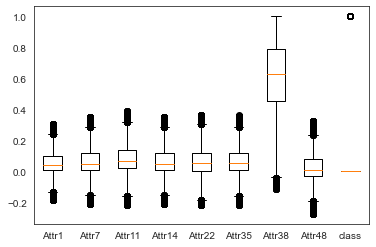

In [66]:
# Create new data frame with variables having high positive correlation
df_positive_relation = df_median_treated[["Attr1","Attr7","Attr11","Attr14","Attr22","Attr35","Attr38", "Attr48", "class"]]
#df_positive_relation.describe().round(3)
plt.boxplot(df_positive_relation, labels = df_positive_relation.columns )
plt.show()
#sns.pairplot(df_positive_relation, hue= "class")

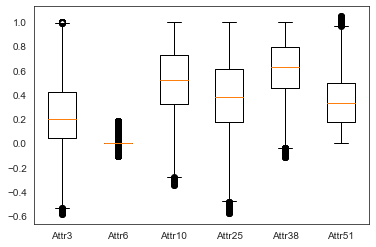

In [40]:
# Create new data frame with variables having high negative correlation
df_negative_relation = df_median_treated[['Attr3','Attr6','Attr10','Attr25','Attr38','Attr51']]
#df_negative_relation.describe().round(3)
plt.boxplot(df_negative_relation, labels = df_negative_relation.columns )
plt.show()

### Feature Selection 
Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d. <br>
SFAs remove or add one feature at the time based on the classifier performance until a feature subset of the desired size k is reached. There are 4 different flavors of SFAs available via the SequentialFeatureSelector:

1. Sequential Forward Selection (SFS)
2. Sequential Backward Selection (SBS)
3. Sequential Forward Floating Selection (SFFS)
4. Sequential Backward Floating Selection (SBFS)

In [ ]:
# Use Sequential Forward Selection (SFS) search  
x = df_median_treated.iloc[:, 0: len(df_median_treated.columns)-1]
y = df_median_treated.iloc[:, -1]
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#x_res, y_res = SMOTE(random_state=42, k_neighbors=10).fit_resample(x_train, y_train) # lets reduce the imbalance
#sm_model = sm.Logit(y_res, x_res, random_state=42)
#sm_fit = sm_model.fit()

knn = KNeighborsClassifier(n_neighbors=10)
sfs1 = SFS(knn, 
           k_features=30, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(x, y, custom_feature_names = x.columns.tolist())
sfs1.subsets_